## Call Imports

In [18]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import scipy as scip
from mpl_toolkits.axes_grid1 import make_axes_locatable

from EWOthello.mingpt.probe_model import BatteryProbeClassification
from EWOthello.mingpt.utils import set_seed
from EWOthello.mingpt.model import GPTConfig,  GPTforProbeIA, GPTforProbeIA_ModV1
from EWOthello.data.othello import * 
from EWOthello.mingpt.dataset import CharDataset 
import EWOthello.utils.plot_helpers as plt_utils
from EWOthello.mingpt.utils import  intervene

set_seed(44)
print(torch.cuda.is_available())
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))

True
NVIDIA GeForce RTX 3090 Ti


## Get Game Data and Define a new intervention function

In [12]:
# Get a the game dataset
othello = get(ood_num=-1, data_root=None, num_preload=1) # 11 corresponds to over 1 million games
game_dataset = CharDataset(othello) 
print("Data Loaded \n")

Max num files: 230; Use_num: 1
['gen10e5__20220324_165952.pickle']


Mem Used: 1.964 GB: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Deduplicating...
Deduplicating finished with 99999 games left
Using 20 million for training, 0 for validation
Dataset created has 99999 sequences, 61 unique words.
Data Loaded 



In [15]:
def run_game_intervention(x, number_moves, intervention_moves, probe_path, probe_layer, reassertion=False, verbose=False, property="New"):
    tbf = [game_dataset.itos[_] for _ in x.tolist()]
    x = x.to(device)
    ab = OthelloBoardState()
    ab.update(tbf[:number_moves], prt=False)
    init_board = np.array(ab.get_state()).reshape(8,8)

    idx_of_interest = number_moves-1 # This corresponds to the index for the next game-move
    padding = torch.zeros(2).cuda() # Add in center two tiles with zero padding because output skips over them

    # Load the GPT Model for gameplay 
    n_layer = int(probe_path[-5:-4])
    n_head = int(probe_path[-3:-2])
    gpt_othello_ckpt = probe_path + f"GPT_Synthetic_{n_layer}Layers_{n_head}Heads.ckpt"
    if verbose: 
        print("Loading GPT Othello from checkpoint: ", gpt_othello_ckpt)
    mconf = GPTConfig(vocab_size=61, block_size=59, n_layer=n_layer, n_head=n_head, n_embd=512)
    model = GPTforProbeIA_ModV1(mconf)
    model.load_state_dict(torch.load(gpt_othello_ckpt))
    model.eval()
    model = model.to(device) 
    
    # Load the set of probes
    probe_set = []
    for layer in range(1,n_layer+1):
        probe = BatteryProbeClassification(device, probe_class=3, num_task=64, input_dim=512)
        probe_ckpt = probe_path + f"linearProbe_Map_{property}_{n_layer}L{n_head}H_GPT_Layer{layer}.ckpt"
        if verbose:
            print(f"Loading Pre-trained probe for layer: {layer}", probe_ckpt)
        probe.load_state_dict(torch.load(probe_ckpt))
        probe.eval()
        probe_set.append(probe)
    
    # Compute the logits with no intervention
    intv_activation = model.forward_1st_stage(-1, x[None, :])[0]
    init_pred, _ = model.predict(intv_activation)
    init_pred = init_pred[idx_of_interest, 1:]
    init_pred = torch.cat([init_pred[:27], padding, init_pred[27:33], padding, init_pred[33:]], dim=0)
    init_pred = init_pred.detach().cpu().reshape(8,8).numpy()

    # Compute the intervention and the new predictions
    htd = {"lr": 1e-3, "steps": 1000, "reg_strg": 0.2}
    interv_boards = []
    interv_preds = []
    actions=[]
    for square in intervention_moves:
        wtd = {}
        wtd["intervention_position"] = square
        tile_number = permit(wtd["intervention_position"])
        r, c = tile_number // 8, tile_number % 8
        wtd["intervention_from"] = ab.state[r, c] + 1
        wtd["intervention_to"] = 2 - wtd["intervention_from"]
        action="No Change" if wtd["intervention_from"] == wtd["intervention_to"] else "Flipped"
        actions.append(f"pos: {square} state {action}")
        
        # Get the layer activation and use probe to get the board state
        intv_activation = model.forward_1st_stage(probe_layer, x[None, :])[0]
        board, _ = probe_set[probe_layer-1](intv_activation)    
        board = torch.argmax(board, -1, keepdim=False)
        
        # Update activation
        post_intv_activation = intervene(probe_set[probe_layer-1], intv_activation.clone()[idx_of_interest,:], board[idx_of_interest,:], wtd, htd, plot=True)
        intv_activation[idx_of_interest, :] = post_intv_activation
        board, _ = probe_set[probe_layer-1](intv_activation)    
        board = torch.argmax(board, -1, keepdim=False)
        board = board[idx_of_interest,:].detach().cpu().reshape(8,8).numpy()
        interv_boards.append(board[None])
        
        if reassertion:
            for i, layer in enumerate(range(probe_layer, n_layer)):
                intv_activation = model.forward_2nd_stage(intv_activation[None], layer, layer+1)[0][0]
                board, _ = probe_set[probe_layer](intv_activation)   
                board = torch.argmax(board, -1, keepdim=False)
                post_intv_activation = intervene(probe_set[probe_layer], intv_activation.clone()[idx_of_interest,:], board[idx_of_interest,:], wtd, htd, plot=True)
                intv_activation[idx_of_interest, :] = post_intv_activation
        else:
            intv_activation = model.forward_2nd_stage(intv_activation[None], probe_layer, -1)[0][0]

        post_intv_pred, _ = model.predict(intv_activation)
        post_intv_pred = post_intv_pred[idx_of_interest, 1:]
        post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)
        post_intv_pred = post_intv_pred.detach().cpu().reshape(8,8).numpy()
        interv_preds.append(post_intv_pred[None])
        
    if len(interv_boards)==1:
        return init_board, init_pred, interv_boards[0], interv_preds[0], actions
    else:
        return init_board, init_pred, np.concatenate(interv_boards, axis=0), np.concatenate(interv_preds, axis=0), actions

## Call Intervention Demonstration (with and without reassertion)

In [16]:
# Game sequence from the dataset chosen by index=#
index = 499
x, _ = game_dataset[index]
number_moves = 5
intervention_moves = ["c3", "c4", "d5"]
probe_path = "../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/"
probe_layer = 6
init_board, init_pred, interv_boards, interv_preds, actions = run_game_intervention(x, number_moves, intervention_moves, probe_path, probe_layer, reassertion=False, verbose=True)

Loading GPT Othello from checkpoint:  ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/GPT_Synthetic_8Layers_8Heads.ckpt
Loading Pre-trained probe for layer: 1 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer1.ckpt
Loading Pre-trained probe for layer: 2 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer2.ckpt
Loading Pre-trained probe for layer: 3 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer3.ckpt
Loading Pre-trained probe for layer: 4 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer4.ckpt
Loading Pre-trained probe for layer: 5 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer5.ckpt
Loading Pre-trained probe for layer: 6 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer6.ckpt
Loading Pre-trained probe for layer: 7 ../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer7.ckpt


Text(0, 0.5, 'Change In Next-Move Prob.')

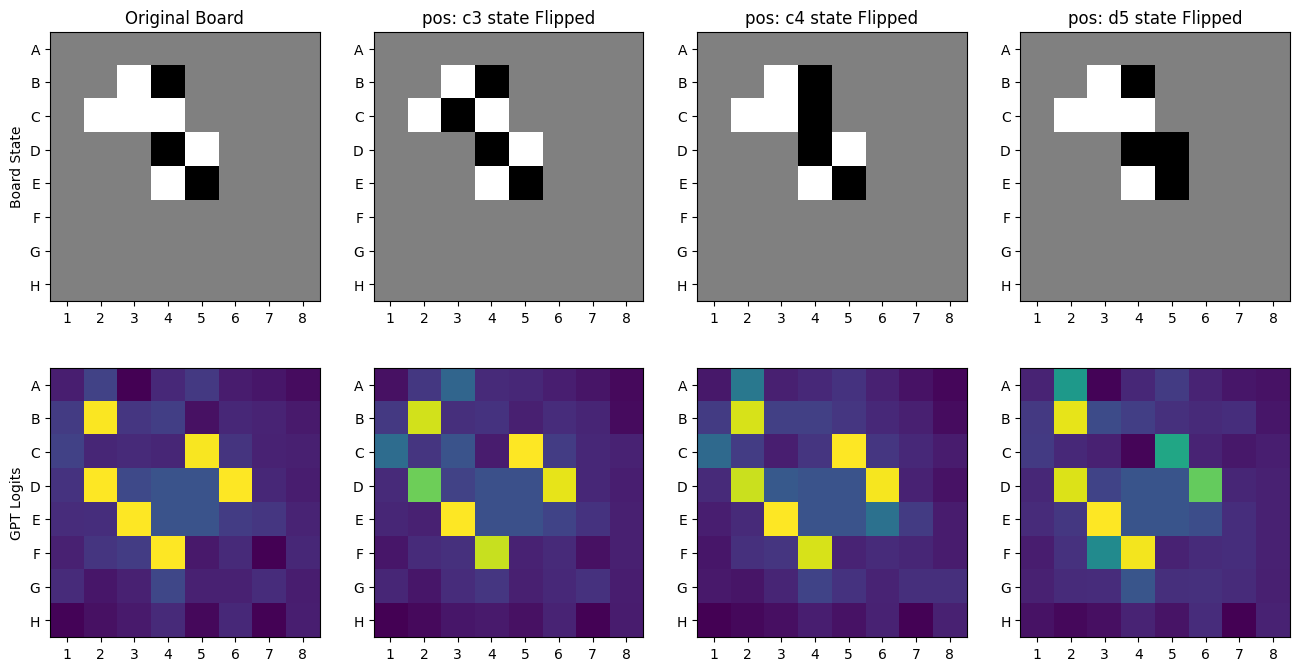

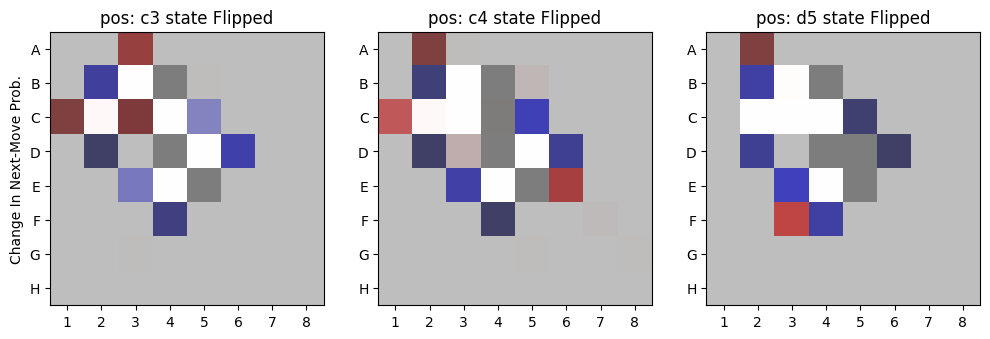

In [17]:
plot_boards = np.concatenate((init_board[None], interv_boards), axis=0)
plot_logits = np.concatenate((init_pred[None], interv_preds), axis=0)
#prob_diff = interv_preds - init_pred[None] 
prob_diff = scip.special.softmax(interv_preds) - scip.special.softmax(init_pred[None])

### PLot the gameboard
num_plot = plot_boards.shape[0]
fig = plt.figure(figsize=(4*num_plot, 8))
ax = plt_utils.addAxis(fig,2,num_plot)
for i in range(num_plot):
    ax[i].imshow(plot_boards[i], cmap="gray")
    ax[i+num_plot].imshow(plot_logits[i])
plt_utils.format_ax_boardImage(ax)
for i in range(num_plot):
    ax[0].set_title("Original Board") if i==0 else ax[i].set_title(actions[i-1])
ax[0].set_ylabel("Board State")
ax[num_plot].set_ylabel("GPT Logits")

### Plot the change plot
num_interv = len(intervention_moves)
fig = plt.figure(figsize=(4*num_interv, 4))
ax = plt_utils.addAxis(fig,1,num_interv)
for i in range(num_interv):
    ax[i].imshow(interv_boards[i], cmap="gray")
    ax[i].set_title(actions[i])
    im = ax[i].imshow(prob_diff[i], alpha=0.5, cmap="seismic", norm=TwoSlopeNorm(0))
    #plt_utils.addColorbar(fig, ax[i], im)
plt_utils.format_ax_boardImage(ax)
ax[0].set_ylabel("Change In Next-Move Prob.")

## Make Latent Saliency Visualizations

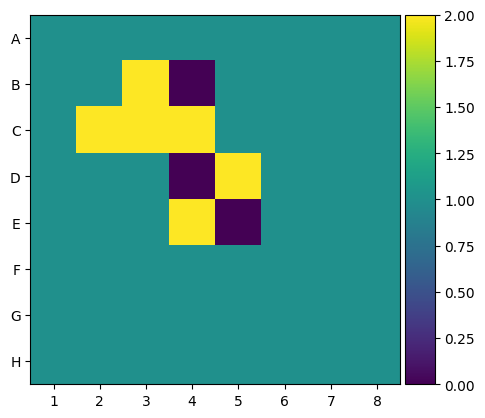

1 2 2.0


In [10]:
def make_latent_saliency_diagram(x, number_moves, inspect_tile, probe_path, probe_layer, reassertion=False, verbose=False, property="New"):
    device = "cpu"
    tbf = [game_dataset.itos[_] for _ in x.tolist()]
    x = x.to(device)
    inspect_int = permit(inspect_tile)

    ab = OthelloBoardState()
    ab.update(tbf[:number_moves], prt=False)
    init_board = np.array(ab.get_state()).reshape(8,8)
    idx_of_interest = number_moves-1 # This corresponds to the index for the next game-move
    padding = torch.zeros(2) if device=="cpu" else torch.zeros(2).cuda() # Add in center two tiles with zero padding because output skips over them

    # Load the GPT Model for gameplay 
    n_layer = int(probe_path[-5:-4])
    n_head = int(probe_path[-3:-2])
    gpt_othello_ckpt = probe_path + f"GPT_Synthetic_{n_layer}Layers_{n_head}Heads.ckpt"
    if verbose: 
        print("Loading GPT Othello from checkpoint: ", gpt_othello_ckpt)
    mconf = GPTConfig(vocab_size=61, block_size=59, n_layer=n_layer, n_head=n_head, n_embd=512)
    model = GPTforProbeIA_ModV1(mconf)
    model.load_state_dict(torch.load(gpt_othello_ckpt))
    model.eval()
    model = model.to(device) 
    
    # Load the set of probes
    probe_set = []
    for layer in range(1,n_layer+1):
        probe = BatteryProbeClassification(device, probe_class=3, num_task=64, input_dim=512)
        probe_ckpt = probe_path + f"linearProbe_Map_{property}_{n_layer}L{n_head}H_GPT_Layer{layer}.ckpt"
        if verbose:
            print(f"Loading Pre-trained probe for layer: {layer}", probe_ckpt)
        probe.load_state_dict(torch.load(probe_ckpt))
        probe.eval()
        probe_set.append(probe)
    
    # Compute the logits with no intervention
    intv_activation = model.forward_1st_stage(-1, x[None, :])[0]
    init_pred, _ = model.predict(intv_activation)
    init_pred = init_pred[idx_of_interest, 1:]
    init_pred = torch.cat([init_pred[:27], padding, init_pred[27:33], padding, init_pred[33:]], dim=0)
    init_pred = init_pred.detach().cpu().numpy()
    init_logit = init_pred[inspect_int]

    # Debugging
    fig = plt.figure()
    ax = plt_utils.addAxis(fig,1,1)
    ax[0].imshow(init_board)
    plt_utils.format_ax_boardImage(ax)
    plt_utils.addColorbar(fig, ax[0])
    plt.show()

    # Compute the intervention and the new predictions
    htd = {"lr": 1e-3, "steps": 1000, "reg_strg": 0.2}
    for tile_number in range(64):
        r, c = tile_number // 8, tile_number % 8
        init_state = init_board[r,c]
        if init_state == 1.0:
            continue

        print(r, c, init_state)

        break
    
        
    return


index = 499
x, _ = game_dataset[index]
number_moves = 5
inspect_tile = "c1"
probe_path = "../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/"
probe_layer = 6

make_latent_saliency_diagram(x, number_moves, inspect_tile, probe_path, probe_layer)






<!-- ## Compare the causality of the old probes -->

In [1]:
# # Game sequence from the dataset chosen by index=#
# index = 499
# x, _ = game_dataset[index]
# number_moves = 5
# intervention_moves = ["c3", "c4", "d5"]
# probe_path = "../EWOthello/ckpts/DeanKLi_GPT_Synthetic_8L8H/"
# probe_layer = 6
# init_board, init_pred, interv_boards, interv_preds, actions = run_game_intervention(x, number_moves, intervention_moves, probe_path, probe_layer, reassertion=False, verbose=True, property="old")

In [2]:
# plot_boards = np.concatenate((init_board[None], interv_boards), axis=0)
# plot_logits = np.concatenate((init_pred[None], interv_preds), axis=0)
# #prob_diff = interv_preds - init_pred[None] 
# prob_diff = scip.special.softmax(interv_preds) - scip.special.softmax(init_pred[None])
# print(np.min(prob_diff), np.max(prob_diff))

# ### PLot the gameboard
# num_plot = plot_boards.shape[0]
# fig = plt.figure(figsize=(4*num_plot, 8))
# ax = plt_utils.addAxis(fig,2,num_plot)
# for i in range(num_plot):
#     ax[i].imshow(plot_boards[i], cmap="gray")
#     ax[i+num_plot].imshow(plot_logits[i])
# plt_utils.format_ax_boardImage(ax)
# for i in range(num_plot):
#     ax[0].set_title("Original Board") if i==0 else ax[i].set_title(actions[i-1])
# ax[0].set_ylabel("Board State")
# ax[num_plot].set_ylabel("GPT Logits")

# ### Plot the change plot
# num_interv = len(intervention_moves)
# fig = plt.figure(figsize=(4*num_interv, 4))
# ax = plt_utils.addAxis(fig,1,num_interv)
# for i in range(num_interv):
#     ax[i].imshow(interv_boards[i], cmap="gray")
#     ax[i].set_title(actions[i])
#     im = ax[i].imshow(prob_diff[i], alpha=0.5, cmap="seismic", norm=TwoSlopeNorm(0))
#     #plt_utils.addColorbar(fig, ax[i], im)
# plt_utils.format_ax_boardImage(ax)
# ax[0].set_ylabel("Change In Next-Move Prob.")